# Bosons in optical tweezers
This Notebook is based on a [paper](https://science.sciencemag.org/content/345/6194/306.abstract) from the Regal group. In this paper, the tunneling of bosons between neighboring sites was observed. With the help of two optical tweezers, at first one and later two bosons were trapped. By bringing the tweezers closer to eachother and by lowering the total trap intensity the boson(s) is(are) able to tunnel from one tweezer to the other. The result of the expirment is observed by distancing the tweezers and measuring the occupation number of the tweezer. 

In the first part of the paper only one atom was trapped in an optical tweezer and the other tweezer was empty.  In the second parts each tweezer was loaded with a boson. We can now measure the probability such that after the tunnneling the bosons are in different tweezers.

In this notebook we will model the experiments within pennlyane.

In [26]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

import strawberryfields as sf
from strawberryfields import ops

%config InlineBackend.figure_format='retina'

# Single Boson

Let us start out with their observations concerning a single Boson, which was initially loaded into the right site. After a given time $t$ they observe the oscillation of the Boson into the left site as seen below.

In [27]:
import pandas as pd

In [28]:
data_kaufman = pd.read_csv('Data/KaufmanData.csv', names = ['t', 'PL'])

Text(0, 0.5, 'probability $P_L$')

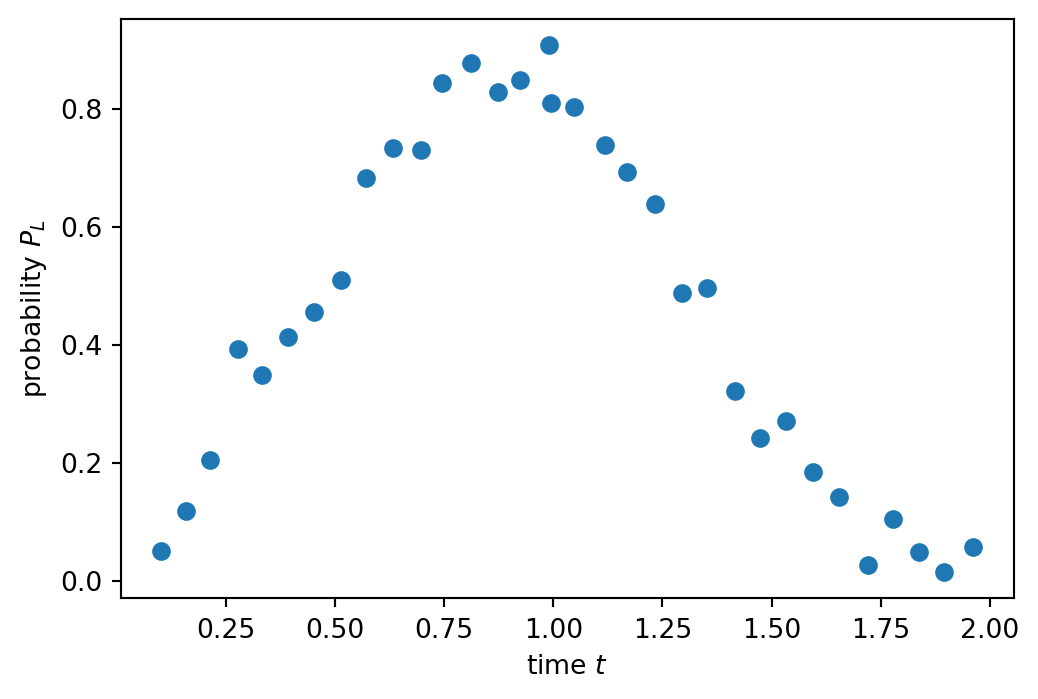

In [29]:
f, ax = plt.subplots(dpi=96)
ax.plot(data_kaufman.t, data_kaufman.PL, 'o');
ax.set_xlabel(r'time $t$')
ax.set_ylabel(r'probability $P_L$')

$$\newcommand{\braket}[3]{\left\langle{#1}\middle|{#2}|{#3}\right\rangle}$$

We will now model these observations through tunnel coupling. The tunnel coupling is given by $J = -\braket{R}{H_{sp}}{L}/\hbar$ where $|L\rangle$ and $|R\rangle$ are the lowest energy states in the left or right well and $H_{sp}$ the Hamiltonian for a single particle. They extracted an experimental tunnel coupling of $J = 2\pi \cdot 262$Hz.

The Tunneling-Hamiltonian for a single boson in a well is given by: 
$\\$
$H_t=$
$\left(\begin{array}{rr} 
0 & J \\ 
J & 0  \\ 
\end{array}\right)$

In [30]:
def Ham_sq(J):
    '''
    The Hamiltonian matrix of the tunneling for a single boson
    '''
    return np.array([[0, J], [J, 0]])

In [7]:
print(Ham_sq(1))

[[0 1]
 [1 0]]


We now want to create a quantum circuit with Pennylane, that simulates the tunneling of a boson from one well to another. We first need to initialize the quantum circuit by raising the number operator of the left well by one (boson 1 is in the left well corresponds to $|L\rangle=1$, $|R\rangle=0$). 

We now have a boson in the left well. After that we use a beamsplitter to represent the tunneling. In the experiment of Cindy Regal the tunneling depended on the time $t$ the wells were swept together. We can simulate the time by tuning the transmittivity of the beamsplitter. This is done by tuning $\theta$ (From the pennylane documentation: "The transmission amplitude of the beamsplitter is $t=cos(\theta)$. The value $\theta=\frac{\pi}{4}$ gives the 50-50 beamsplitter."), and get a curve for the probabilities of the boson (see Plot. 1) being in the right or left well.

![circuit](Gates/Single_Boson_Left.svg)

We initiate a single boson in the left well and then perform a beamsplitter gate on the system. We can then measure the occupation number $|n\rangle_L$ and $|n\rangle_R$ which is dependent on $\theta$.

There are two ways to initiate the boson in the left well:
* [Displacement gate](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.Displacement.html)
* [Fock state Gate](https://pennylane.readthedocs.io/en/stable/code/api/pennylane.FockState.html)

While using the displacement gate and fock state gate does not differ when only having a single boson in the well, its evaluation differs when considering a two boson system. We will later see why this is the case and how to overcome this issue.

In [8]:
dev_boson = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)

@qml.qnode(dev_boson)
def single_boson(x, theta, var=False):
    """
    Single Boson well tunneling circuit using the displacement gate
    """
    qml.Displacement(x, 0, wires=0)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]

In [9]:
single_boson(1, np.pi/4)
print(single_boson.draw())

 0: ──D(1.0, 0)──╭BS(0.785, 0)──┤ ⟨n⟩ 
 1: ─────────────╰BS(0.785, 0)──┤ ⟨n⟩ 



In [10]:
dev_boson = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)

@qml.qnode(dev_boson)
def single_boson_fock(theta, var=False):
    """
    Single Boson well tunneling circuit using the fock state gate
    """
    qml.FockState(1, wires=0)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    if var:  
        return [qml.var(qml.NumberOperator(0)),qml.var(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]



In [11]:
single_boson_fock(np.pi/4)
print(single_boson_fock.draw())

 0: ──|1⟩──╭BS(0.785, 0)──┤ ⟨n⟩ 
 1: ───────╰BS(0.785, 0)──┤ ⟨n⟩ 



In [12]:
thetas = np.linspace(0, np.pi, 100)
res_dis = np.array([single_boson(1, theta) for theta in thetas])
res_fock = np.array([single_boson_fock(theta) for theta in thetas])

And we print out the resulting evolution.

Text(0, 0.5, 'Probability')

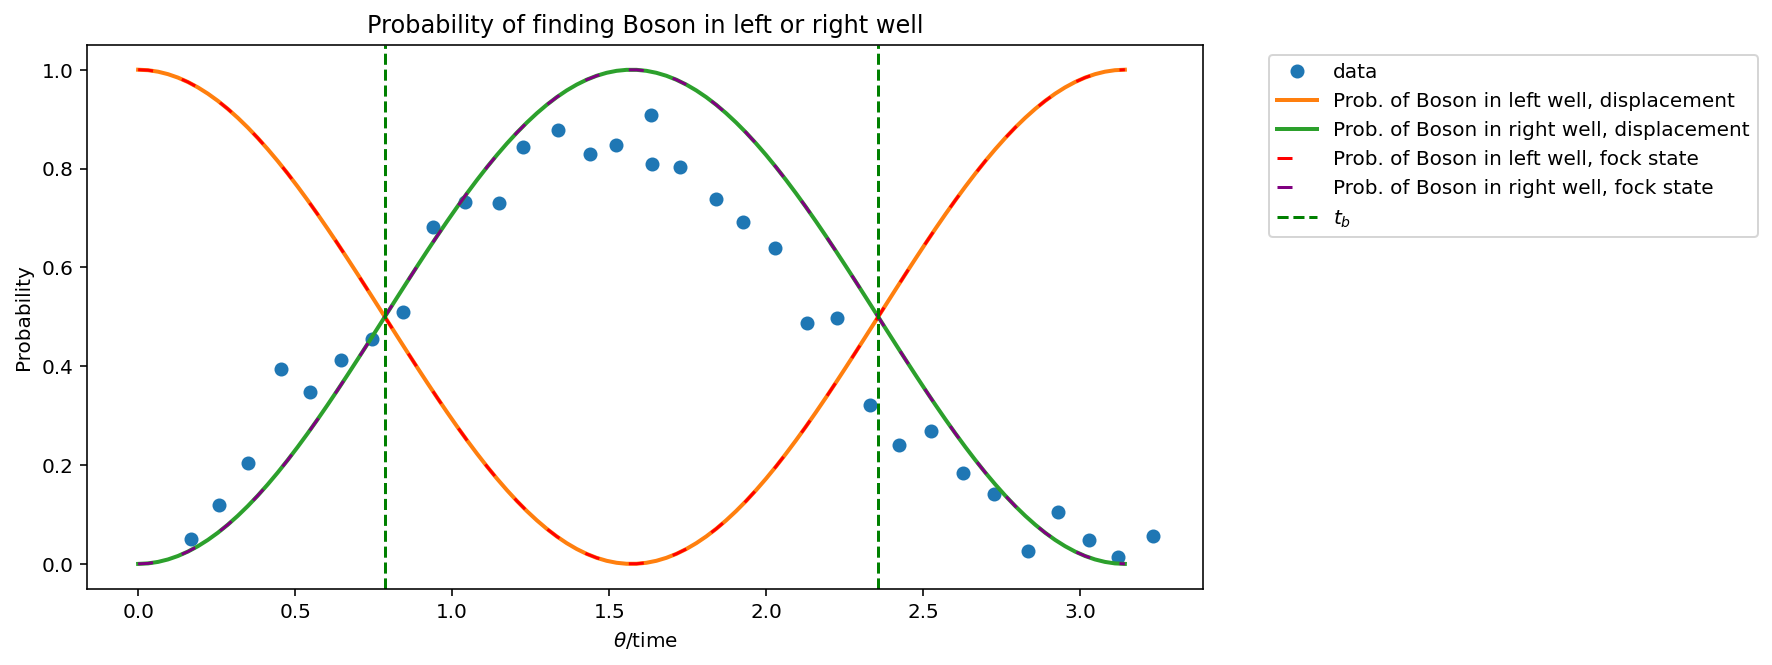

In [13]:
Jexp = 262*2*np.pi;
thetaExp = data_kaufman.t*1e-3*Jexp;

f, ax = plt.subplots(figsize = (10,5))
ax.plot(thetaExp, data_kaufman.PL, 'o', label='data');

ax.plot(thetas, res_dis[:, 0], label="Prob. of Boson in left well, displacement", linewidth=2)
ax.plot(thetas, res_dis[:, 1], label="Prob. of Boson in right well, displacement", linewidth=2)

ax.plot(thetas, res_fock[:, 0], linestyle=(0, (5, 10)), label="Prob. of Boson in left well, fock state", color="red")
ax.plot(thetas, res_fock[:, 1], linestyle=(0, (5, 10)), label="Prob. of Boson in right well, fock state", color="purple")


ax.axvline(x=np.pi/4, linestyle="--", color="green", label="$t_b$")
ax.axvline(x=3*np.pi/4, linestyle="--", color="green")
ax.set_title("Probability of finding Boson in left or right well")
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("$\\theta$/time")
ax.set_ylabel("Probability")

We can clearly see, that the results are identical and model the results from the paper quite well.

## Variances

We can now investigate the differences between the intial preparation with a displacement or a Fock state. For this we will look at the variance of the measured expectation values. As we will see, only the Fock state explains the epxerimentally observed fluctuations properly, which fairly even for all times.

In [14]:
var_displacement = np.array([single_boson(1, theta, var=True) for theta in thetas])
var_fock = np.array([single_boson_fock(theta, var=True) for theta in thetas])

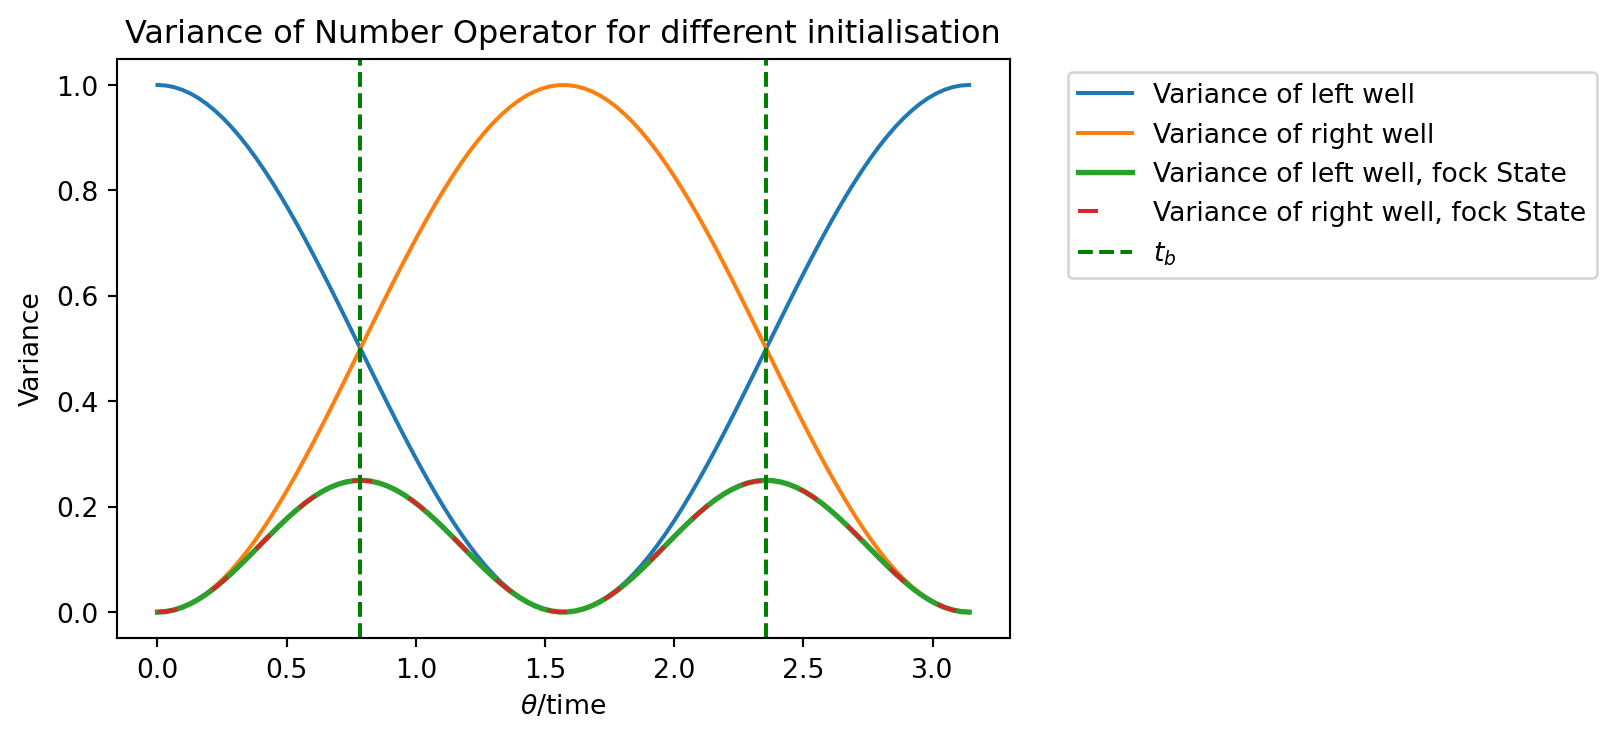

In [15]:
plt.figure(dpi=96)

plt.plot(thetas, var_displacement[:, :1], label="Variance of left well")
plt.plot(thetas, var_displacement[:, 1:], label="Variance of right well")

plt.plot(thetas,var_fock[:, 1:], label="Variance of left well, fock State", linewidth=2)
plt.plot(thetas,var_fock[:, :1], linestyle=(0, (5, 10)), label="Variance of right well, fock State")



plt.axvline(x=np.pi/4, linestyle="--", color="green", label="$t_b$")
plt.axvline(x=3*np.pi/4, linestyle="--", color="green")
plt.title("Variance of Number Operator for different initialisation")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("$\\theta$/time")
_ = plt.ylabel("Variance")

We can clearly see, that the variance has a maximum for the displacement, when the boson is either in the left or the right well. This can be explained by the nature of the displacement gate. It produces a state in which sometimes 0, 1, 2 or more(?) bosons are in the (in our case left) well, but on average 1 boson is present. The beamsplitter shifts the variance as well as the expectation value from one well to the other.

The fock State on the other hand has a variance of 0 when being initiated. In the case of the beamsplitter being exactly reflective or exactly transmissive, the variance is 0. When the beamsplitter is symmetric ($\theta = \frac{\pi}{4}$,$\frac{3\pi}{4}$) the variance has a peak. The variances of both wells are exactly equal. 

## Two Bosons

We can now initiate the Circuit with a boson in each well. The difference between the two possibilities of initiating the wells become clearer now.

![circuit](Gates/Two_Bosons.svg)


In [16]:
dev_boson = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)
@qml.qnode(dev_boson)
def two_bosons(x_1, x_2, theta, var=False):
    qml.Displacement(x_1, 0, wires=0)
    qml.Displacement(x_2, 0, wires=1)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    if var:       
        return [qml.var(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]
    else:
        return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]

In [17]:
dev_boson = qml.device('strawberryfields.fock', wires=2, cutoff_dim=10)

@qml.qnode(dev_boson)
def two_bosons_fock(theta):
    qml.FockState(1, wires=0)
    qml.FockState(1, wires=1)
    qml.Beamsplitter(theta, 0, wires=[0, 1])
    return [qml.expval(qml.NumberOperator(0)),qml.expval(qml.NumberOperator(1))]

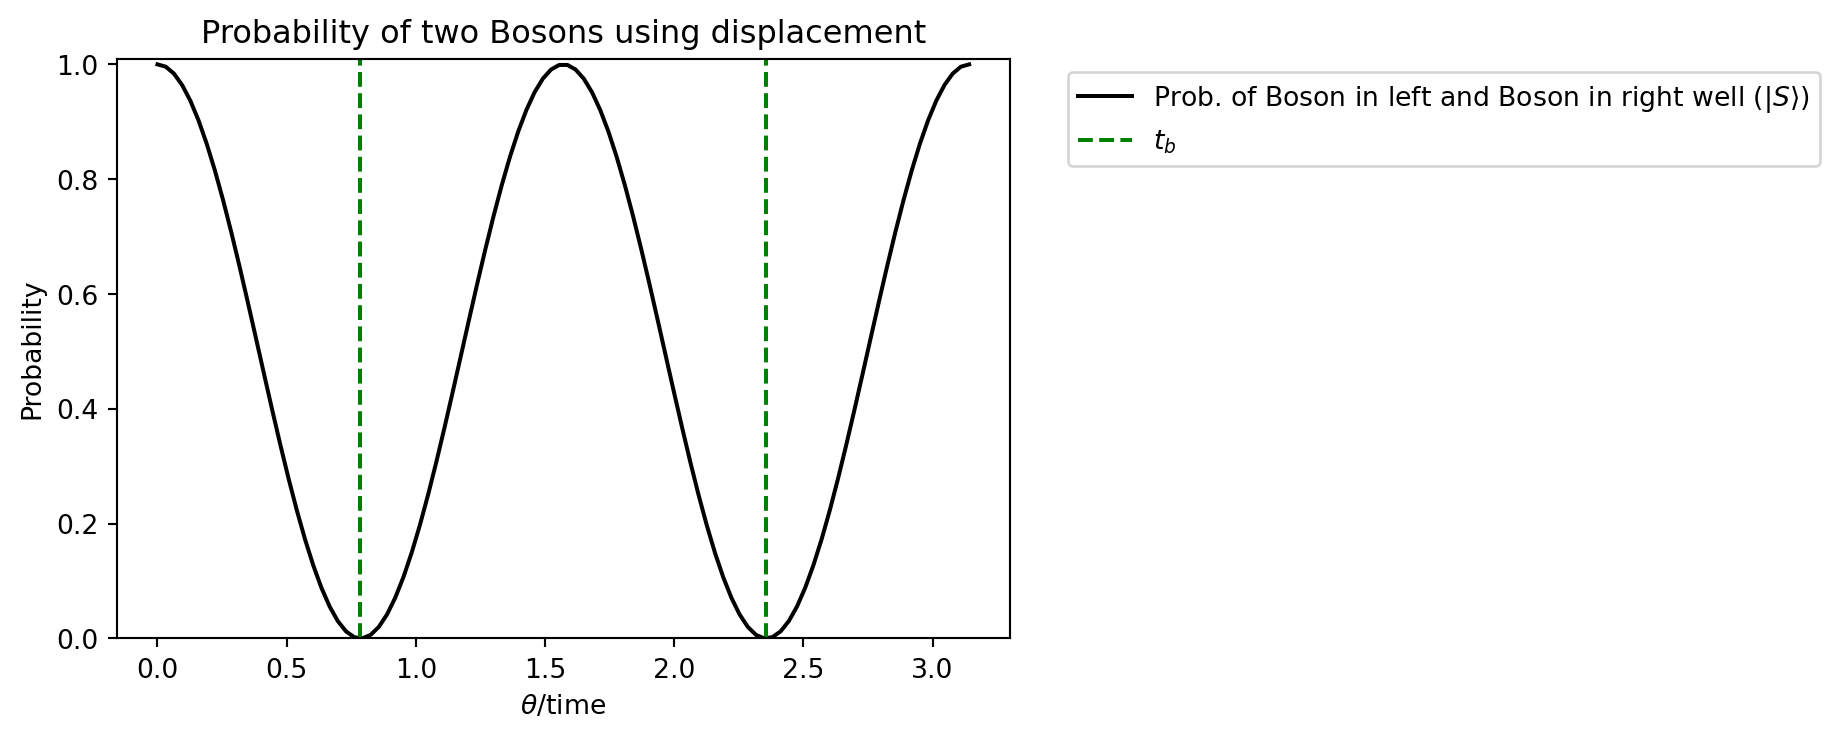

In [18]:
thetas = np.linspace(0, np.pi, 100)

res = np.array([two_bosons(1, 1, theta) for theta in thetas])

plt.figure(dpi=96)
plt.plot(thetas, res[:, 1]*res[:, 0], label=r"Prob. of Boson in left and Boson in right well ($|S\rangle$)", color="black")
plt.ylim(0, 1.01)
plt.axvline(x=np.pi/4, linestyle="--", color="green", label="$t_b$")
plt.axvline(x=3*np.pi/4, linestyle="--", color="green")
plt.title(r"Probability of two Bosons using displacement")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r"$\theta$/time")
_ = plt.ylabel("Probability")

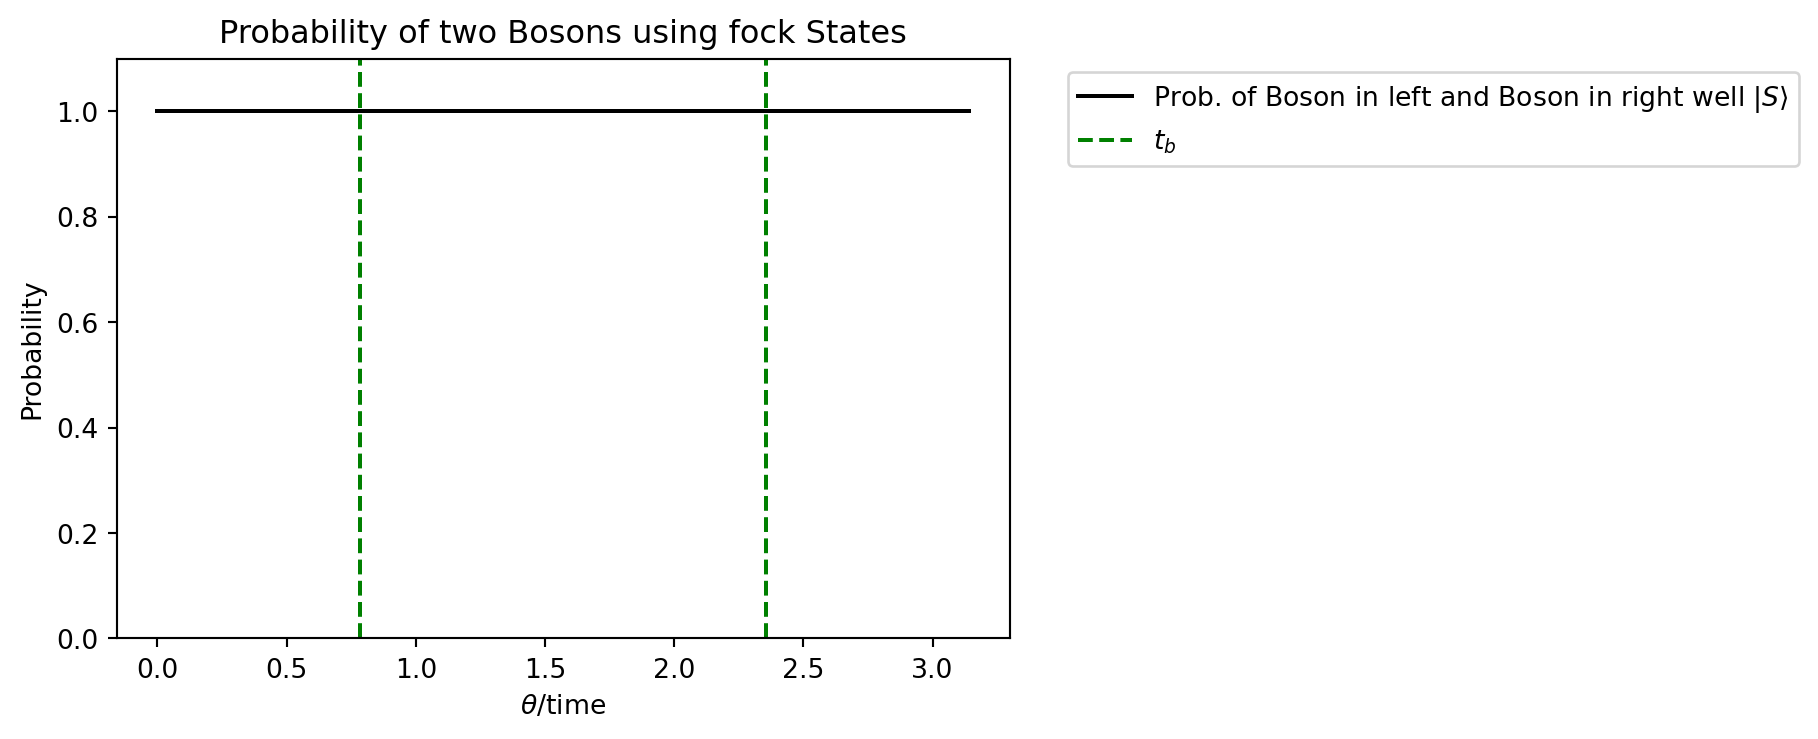

In [19]:
thetas = np.linspace(0, np.pi, 100)

res = np.array([two_bosons_fock(theta) for theta in thetas])

plt.figure(dpi=96)
plt.plot(thetas, res[:, 1]*res[:, 0], label=r"Prob. of Boson in left and Boson in right well $|S\rangle$", color="black")
plt.ylim(0, 1.1)
plt.axvline(x=np.pi/4, linestyle="--", color="green", label="$t_b$")
plt.axvline(x=3*np.pi/4, linestyle="--", color="green")
plt.title(r"Probability of two Bosons using fock States")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r"$\theta$/time")
_ = plt.ylabel("Probability")

Since there is a boson in each well on average, and we extract the expectation value of the number operator pennylane returns ```[1, 1]``` for each $\theta$. We want to understand this behavior more thoroughly. To do this we use the strawberry fields package without having pennylane as the "middleman". In the following the same circuit is created with the strawberryfields syntax.

In [20]:
def circuit(theta):
    prog = sf.Program(2)
    with prog.context as q:
        ops.Fock(1) | q[0]
        ops.Fock(1) | q[1]
        ops.BSgate(theta, 0) | (q[0], q[1])
        ops.MeasureFock()| q
    eng = sf.Engine("fock", backend_options={"cutoff_dim" :  10})
    result = eng.run(prog)
    return result

We can now run the circuit multiple times and extract the final values for the number operator of the left and right well.

In [21]:
theta_samples = 6
shots = 5
res = np.zeros((theta_samples, shots, 2))
thetas = np.linspace(0, np.pi, theta_samples)

for n, theta in enumerate(thetas):
    print(f"Calculating theta={theta:.2f}", end='\r')
    for i in range(shots):
        result = circuit(theta)
        
        res[n, i, 0] = result.samples[0, 0]
        res[n, i, 1] = result.samples[0, 1]
print("""

Each row represents one shot, while the grouped shots represent the results for a specific value of theta
""")
print(res)

print("""
Mean value of each value of theta
""", res.mean(axis=1))

Calculating theta=3.14

Each row represents one shot, while the grouped shots represent the results for a specific value of theta

[[[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]

 [[2. 0.]
  [2. 0.]
  [0. 2.]
  [2. 0.]
  [2. 0.]]

 [[1. 1.]
  [1. 1.]
  [0. 2.]
  [2. 0.]
  [1. 1.]]

 [[2. 0.]
  [1. 1.]
  [1. 1.]
  [0. 2.]
  [2. 0.]]

 [[2. 0.]
  [0. 2.]
  [0. 2.]
  [2. 0.]
  [2. 0.]]

 [[1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]
  [1. 1.]]]

Mean value of each value of theta
 [[1.  1. ]
 [1.6 0.4]
 [1.  1. ]
 [1.2 0.8]
 [1.2 0.8]
 [1.  1. ]]


At first sight it seems as if there is some fluctuation in the simulated data. However if we run the circuit 1000 times for each value of $\theta$ the average of each $\theta$ of each well approaches $1$. 

In [22]:
theta_samples = 15
shots = 1000
res = np.zeros((theta_samples, shots, 2))
thetas = np.linspace(0, np.pi, theta_samples)

for n, theta in enumerate(thetas):
    print(f"Calculating theta={theta:.2f}", end='\r')
    for i in range(shots):
        result = circuit(theta)
        
        res[n, i, 0] = result.samples[0, 0]
        res[n, i, 1] = result.samples[0, 1]
print("")

res.mean(axis=1)

Calculating theta=3.14


array([[1.   , 1.   ],
       [0.985, 1.015],
       [1.002, 0.998],
       [0.948, 1.052],
       [0.962, 1.038],
       [0.968, 1.032],
       [0.98 , 1.02 ],
       [1.   , 1.   ],
       [0.995, 1.005],
       [0.994, 1.006],
       [1.015, 0.985],
       [1.049, 0.951],
       [1.032, 0.968],
       [0.987, 1.013],
       [1.   , 1.   ]])

Since we are not interested in the average number operator of each well, but in the distribution of the bosons in the wells ($|L\rangle=2$, $|R\rangle=2$ vs $|L\rangle=1$, $|R\rangle=1$) we need to extract this information from the generated data. This is done by counting all instances where both bosons are either in the left($|L\rangle=2$) or the right well ($|R\rangle=2$) and calculating the ratio. The error is $\frac{1}{\sqrt{N}}$ with N being the number of shots per value of $\theta$.

In [23]:
theta_samples = 15
shots = 300
res_fock = np.zeros((theta_samples, shots, 2))
thetas = np.linspace(0, np.pi, theta_samples)

for n, theta in enumerate(thetas):
    print(f"Calculating theta={theta:.2f}", end='\r')
    for i in range(shots):
        result = circuit(theta)
        
        res_fock[n, i, 0] = result.samples[0, 0]
        res_fock[n, i, 1] = result.samples[0, 1]

In [24]:
one_in_each = np.logical_or(res_fock==[2., 0.], res_fock==[0., 2.])
prob = 1-(one_in_each.sum(axis=1)[:, :1]/shots)
prob_err = np.ones(theta_samples)/np.sqrt(shots)

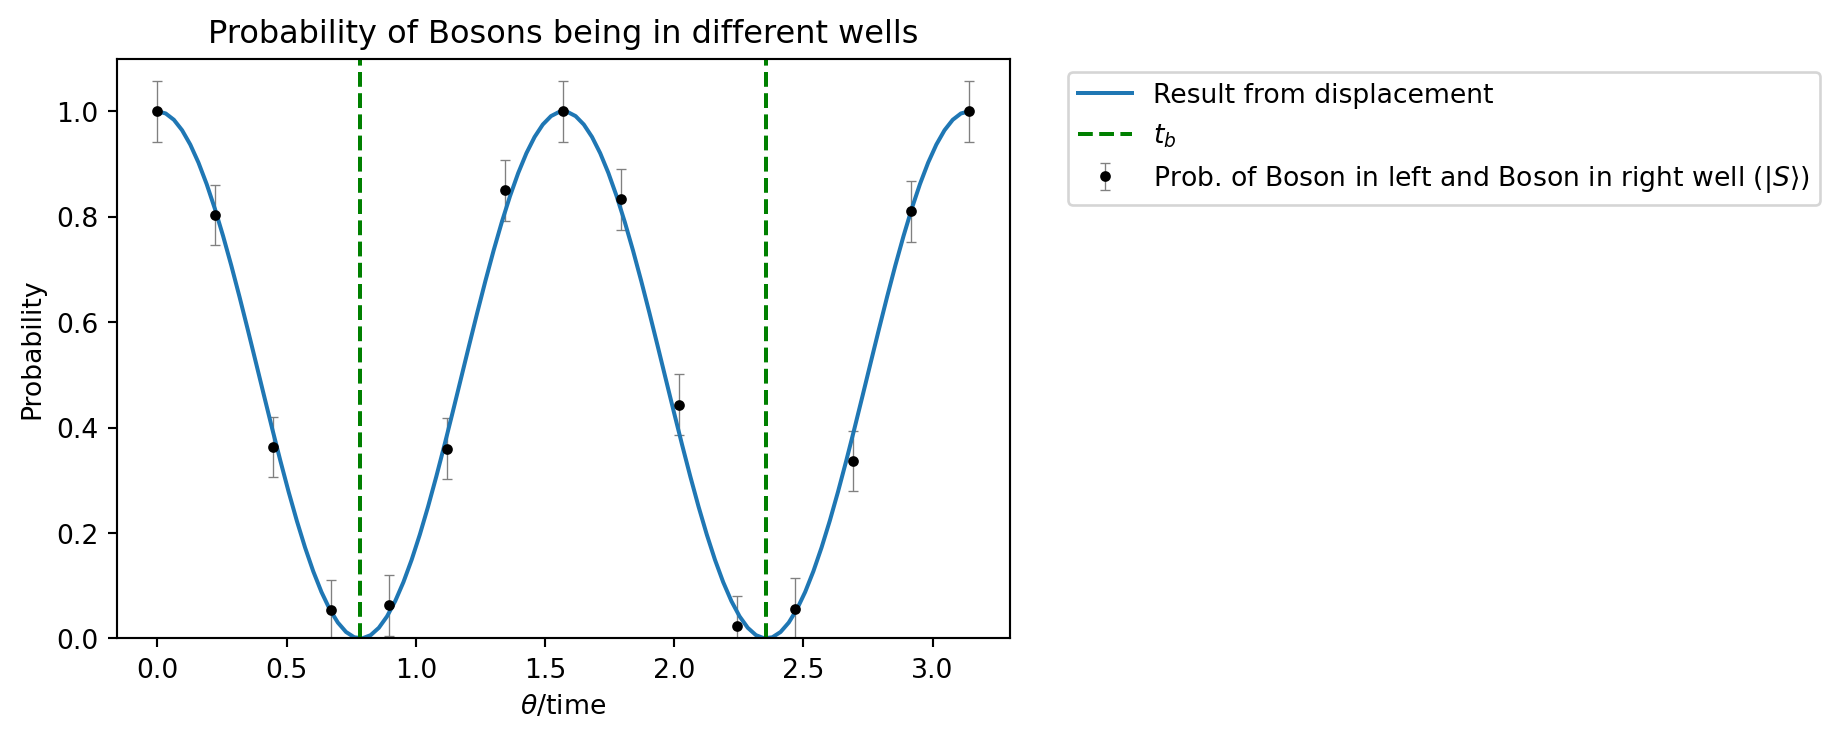

In [25]:
thetas_fit = np.linspace(0, np.pi, 100)
thetas = np.linspace(0, np.pi, theta_samples)


res_fit = np.array([two_bosons(1, 1, theta) for theta in thetas_fit])

plt.figure(dpi=96)
plt.errorbar(thetas, prob, fmt=".", yerr=prob_err, capsize=2, elinewidth=0.5, capthick=0.5, ecolor='gray',
            label=r"Prob. of Boson in left and Boson in right well ($|S\rangle$)", color="black")
plt.plot(thetas_fit, res_fit[:, :1]*res_fit[:, 1:], label="Result from displacement")
plt.ylim(0, 1.1)
plt.axvline(x=np.pi/4, linestyle="--", color="green", label="$t_b$")
plt.axvline(x=3*np.pi/4, linestyle="--", color="green")
plt.title(r"Probability of Bosons being in different wells")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r"$\theta$/time")
_ = plt.ylabel("Probability")

We can see that this matches the result of the displacement gate quite well.